In [129]:
import pandas as pd
import pickle
import Quandl, math, datetime
import numpy as np
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline

style.use('ggplot')

In [130]:
df = Quandl.get('WIKI/GOOGL')

In [131]:
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.00,104.06,95.96,100.34,44659000.0,0.0,1.0,50.000,52.03,47.980,50.170,44659000.0
2004-08-20,101.01,109.08,100.50,108.31,22834300.0,0.0,1.0,50.505,54.54,50.250,54.155,22834300.0
2004-08-23,110.75,113.48,109.05,109.40,18256100.0,0.0,1.0,55.375,56.74,54.525,54.700,18256100.0
2004-08-24,111.24,111.60,103.57,104.87,15247300.0,0.0,1.0,55.620,55.80,51.785,52.435,15247300.0
2004-08-25,104.96,108.00,103.88,106.00,9188600.0,0.0,1.0,52.480,54.00,51.940,53.000,9188600.0


In [132]:
df = df[['Adj. Open','Adj. Close','Adj. High','Adj. Low','Adj. Volume' ]]

In [133]:
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low'])/ df['Adj. Close'] * 100.0

In [134]:
df['PCT_Change'] = (df['Adj. Close'] - df['Adj. Open'])/ df['Adj. Open'] * 100.0

In [135]:
df = df[['Adj. Close', 'HL_PCT', 'PCT_Change', 'Adj. Volume']]
df.head()

,Adj. Close,HL_PCT,PCT_Change,Adj. Volume
Date,,,,
2004-08-19,50.170,8.072553,0.340000,44659000.0
2004-08-20,54.155,7.921706,7.227007,22834300.0
2004-08-23,54.700,4.049360,-1.218962,18256100.0
2004-08-24,52.435,7.657099,-5.726357,15247300.0
2004-08-25,53.000,3.886792,0.990854,9188600.0


In [136]:
forecast_col = 'Adj. Close'

In [137]:
df.is_copy = False

# df.fillna(-99999.0,inplace=True)

In [138]:
df.describe()

,Adj. Close,HL_PCT,PCT_Change,Adj. Volume
count,3014.000000,3014.000000,3014.000000,3.014000e+03
mean,338.646567,2.207070,-0.023674,8.641007e+06
std,180.508620,1.421595,1.560854,8.457977e+06
min,50.005000,0.000000,-9.179757,5.211410e+05
25%,218.343750,1.306414,-0.801740,3.440100e+06
50%,283.642500,1.845063,-0.026639,5.880200e+06
75%,443.480000,2.633136,0.795976,1.135105e+07
max,808.490000,16.278749,8.759770,8.215110e+07


In [139]:
forecast_out = int(math.ceil(0.1*len(df)))

In [140]:
df['label'] = df[forecast_col].shift(-forecast_out)

In [141]:

df['Adj. Volume'] = (df['Adj. Volume'] - df['Adj. Volume'].mean()) / df['Adj. Volume'].mean()

In [142]:
X = np.array(df.drop(['label'],1))#.as_matrix().astype(float)
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]


df.dropna(inplace=True)
y = np.array(df['label'])
df.head()

,Adj. Close,HL_PCT,PCT_Change,Adj. Volume,label
Date,,,,,
2004-08-19,50.170,8.072553,0.340000,4.168263,179.085
2004-08-20,54.155,7.921706,7.227007,1.642551,186.070
2004-08-23,54.700,4.049360,-1.218962,1.112728,189.690
2004-08-24,52.435,7.657099,-5.726357,0.764528,189.840
2004-08-25,53.000,3.886792,0.990854,0.063371,192.975


In [143]:
X.shape, y.shape

((2712, 4), (2712,))

In [144]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)

In [145]:
pickle_in = open('linearregression.pickle','rb')
clf = pickle.load(pickle_in)

# clf = LinearRegression(n_jobs = -1)
# clf.fit(X_train, y_train)

In [146]:
accuracy = clf.score(X_test, y_test)
accuracy

0.64534162734815981

In [147]:
# for ker in ['linear','poly','rbf','sigmoid']:
#     clf = svm.SVR(kernel=ker)
#     clf.fit(X_train, y_train)
#     accuracy = clf.score(X_test, y_test)
#     print(accuracy)

In [148]:
forecast_set = clf.predict(X_lately)

In [156]:
#print(forecast_set, accuracy, forecast_out)

In [150]:
df['Forecast'] = np.nan

In [151]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

In [152]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]

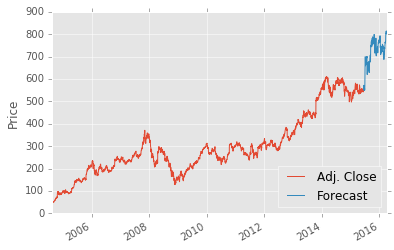

In [153]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.ylabel('Price')
plt.show()

In [154]:
with open('linearregression.pickle','wb') as f:
    pickle.dump(clf,f)

In [155]:
pickle_in = open('linearregression.pickle','rb')
clf = pickle.load(pickle_in)